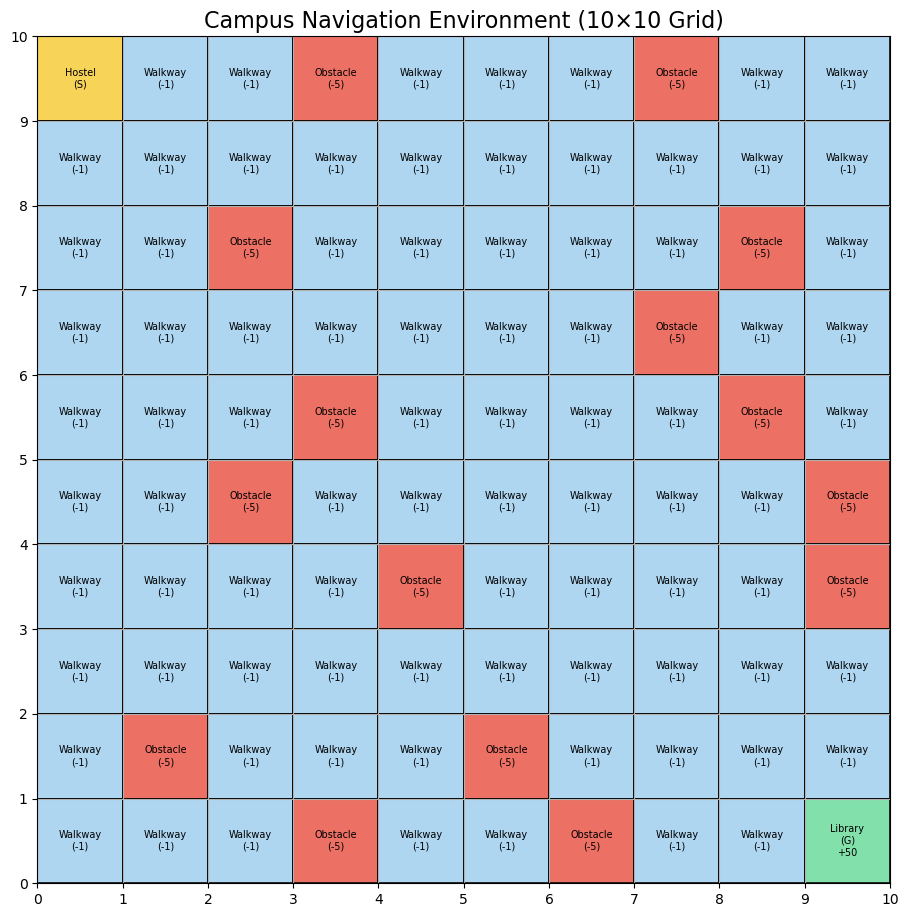

In [14]:
# ================================================================
#                CAMPUS NAVIGATION ENVIRONMENT (10×10)
# ================================================================

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle, FancyArrow

# ---------------------------------------------------
# 1️⃣ Grid Size, Start, Goal, Actions
# ---------------------------------------------------
rows, cols = 10, 10

START = (0, 0)
GOAL = (9, 9)

ACTIONS = [
    (-1, 0),  # Up
    (1, 0),   # Down
    (0, -1),  # Left
    (0, 1)    # Right
]

# ---------------------------------------------------
# 2️⃣ Obstacles
# ---------------------------------------------------
OBSTACLES = [
    (0, 3), (0, 7),
    (2, 8), (2, 2),
    (3, 7),
    (4, 3), (4, 8),
    (5, 2), (5, 9),
    (6, 4), (6, 9),
    (8, 1), (8, 5),
    (9, 3), (9, 6)
]

# ---------------------------------------------------
# 3️⃣ Rewards
# ---------------------------------------------------
REWARD_NORMAL   = -1
REWARD_OBSTACLE = -5
REWARD_GOAL     = 50
REWARD_INVALID  = -1


# ---------------------------------------------------
# STEP FUNCTION (UPDATED 🚀)
# ---------------------------------------------------
def step(state, action):
    r, c = state
    dr, dc = action
    nr, nc = r + dr, c + dc

    # OUT OF BOUNDS → stay in same place + penalty
    if nr < 0 or nr >= rows or nc < 0 or nc >= cols:
        return state, REWARD_INVALID, False

    next_state = (nr, nc)

    # OBSTACLE HIT → stay in same cell, give penalty, continue episode
    if next_state in OBSTACLES:
        return state, REWARD_OBSTACLE, False   # <-- IMPORTANT CHANGE

    # GOAL → end episode
    if next_state == GOAL:
        return next_state, REWARD_GOAL, True

    # NORMAL WALKWAY
    return next_state, REWARD_NORMAL, False


# ---------------------------------------------------
# COLOR FUNCTION
# ---------------------------------------------------
def cell_color(pos):
    if pos == START: return '#f7d358'
    if pos == GOAL: return '#82e0aa'
    if pos in OBSTACLES: return '#ec7063'
    return '#aed6f1'


# ---------------------------------------------------
# LABELS FOR EACH CELL
# ---------------------------------------------------
cell_labels = {}
for r in range(rows):
    for c in range(cols):
        cell_labels[(r, c)] = f"Walkway\n({REWARD_NORMAL})"

for pos in OBSTACLES:
    cell_labels[pos] = f"Obstacle\n({REWARD_OBSTACLE})"

cell_labels[START] = "Hostel\n(S)"
cell_labels[GOAL] = f"Library\n(G)\n+{REWARD_GOAL}"


# ---------------------------------------------------
# VISUALIZE GRID
# ---------------------------------------------------
def visualize_environment():
    fig, ax = plt.subplots(figsize=(11, 11))

    for r in range(rows):
        for c in range(cols):
            ax.add_patch(Rectangle(
                (c, rows - 1 - r), 1, 1,
                facecolor=cell_color((r, c)),
                edgecolor='black', linewidth=1.2
            ))
            ax.text(
                c + 0.5,
                rows - 1 - r + 0.5,
                cell_labels[(r, c)],
                ha='center', va='center',
                fontsize=7, wrap=True
            )

    ax.set_xticks(range(cols + 1))
    ax.set_yticks(range(rows + 1))
    ax.grid(True)
    ax.set_title("Campus Navigation Environment (10×10 Grid)", fontsize=16)
    plt.show()


# ---------------------------------------------------
# VISUALIZE PATH
# ---------------------------------------------------
def visualize_path(path, cost, method_name, color="black"):
    fig, ax = plt.subplots(figsize=(11, 11))

    for r in range(rows):
        for c in range(cols):
            ax.add_patch(Rectangle(
                (c, rows - 1 - r), 1, 1,
                facecolor=cell_color((r, c)),
                edgecolor='black', linewidth=1.2
            ))
            ax.text(
                c + 0.5,
                rows - 1 - r + 0.5,
                cell_labels[(r, c)],
                ha='center', va='center',
                fontsize=7, wrap=True
            )

    for i in range(len(path) - 1):
        r1, c1 = path[i]
        r2, c2 = path[i + 1]
        ax.add_patch(FancyArrow(
            c1 + 0.5, rows - 1 - r1 + 0.5,
            (c2 - c1), -(r2 - r1),
            width=0.05,
            head_width=0.25,
            head_length=0.25,
            color=color,
            length_includes_head=True
        ))

    ax.set_title(f"{method_name} — Path Cost = {cost}", fontsize=16)
    ax.grid(True)
    ax.set_xticks(range(cols + 1))
    ax.set_yticks(range(rows + 1))
    plt.show()


# ---------------------------------------------------
# SHOW ENVIRONMENT IMMEDIATELY
# ---------------------------------------------------
visualize_environment()


Q-Learning Path: [(0, 0), (0, 1), (1, 1), (1, 2), (1, 3), (1, 4), (2, 4), (2, 5), (3, 5), (4, 5), (5, 5), (6, 5), (6, 6), (7, 6), (8, 6), (8, 7), (9, 7), (9, 8), (9, 9)]
Q-Learning Cost: 32
Q-Learning Final Episode Reward: 33


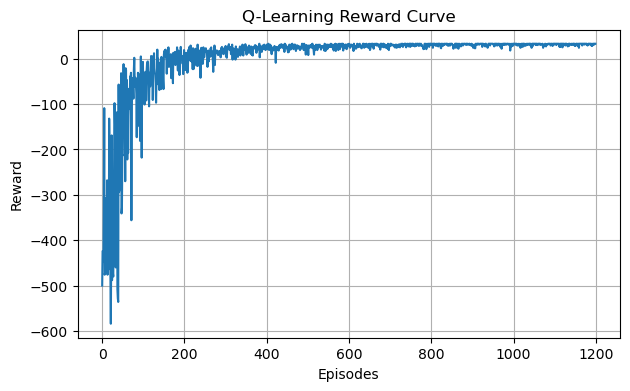

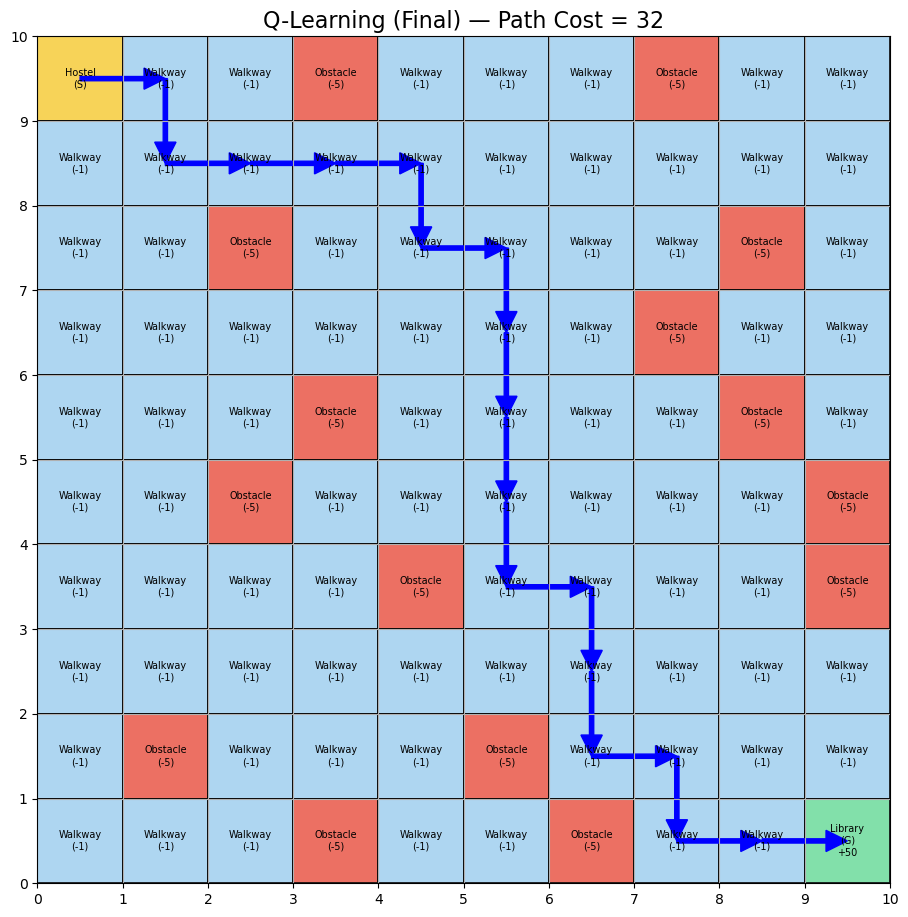

In [15]:
# ===========================
# Q-LEARNING (main logic cell)
# ===========================
import numpy as np
from matplotlib import pyplot as plt

# deterministic RNG (optional, for reproducibility)
SEED = 42
rng = np.random.default_rng(SEED)
np.random.seed(SEED)

alpha = 0.15
gamma = 0.95
episodes = 1200
max_steps = 300

# Q-table
Q = np.zeros((rows, cols, len(ACTIONS)))
rewards_q = []

# epsilon schedule
eps_start, eps_end, decay = 1.0, 0.02, 0.003

def select_eps_greedy(Qtable, state, eps):
    if rng.random() < eps:
        return int(rng.integers(0, len(ACTIONS)))
    return int(np.argmax(Qtable[state]))

def evaluate_greedy_policy(Qtable, max_steps_eval=500):
    s = START
    path = [s]
    visited = set([s])
    for _ in range(max_steps_eval):
        a = int(np.argmax(Qtable[s]))
        dr, dc = ACTIONS[a]
        ns, r, done = step(s, ACTIONS[a])
        # if agent stays (invalid or obstacle caused stay) or revisits -> stop
        if ns == s or ns in visited:
            break
        path.append(ns)
        visited.add(ns)
        if done:
            break
        s = ns
    return path

for ep in range(episodes):
    s = START
    total = 0
    eps = eps_end + (eps_start - eps_end) * np.exp(-decay * ep)
    for t in range(max_steps):
        a = select_eps_greedy(Q, s, eps)
        ns, r, done = step(s, ACTIONS[a])

        # Q update (even if ns == s because of obstacle penalty)
        Q[s][a] += alpha * (r + gamma * np.max(Q[ns]) - Q[s][a])

        total += r
        s = ns
        if done:
            break
    rewards_q.append(total)

# Evaluate final greedy policy
path_q = evaluate_greedy_policy(Q)
# compute cost using simple sum consistent with environment labels
cost_q = 0
for cell in path_q:
    if cell == GOAL:
        cost_q += REWARD_GOAL; break
    elif cell in OBSTACLES:
        cost_q += REWARD_OBSTACLE
    else:
        cost_q += REWARD_NORMAL

print("Q-Learning Path:", path_q)
print("Q-Learning Cost:", cost_q)
print("Q-Learning Final Episode Reward:", rewards_q[-1])

plt.figure(figsize=(7,4)); plt.plot(rewards_q); plt.title("Q-Learning Reward Curve"); plt.xlabel("Episodes"); plt.ylabel("Reward"); plt.grid(True); plt.show()
visualize_path(path_q, cost_q, "Q-Learning (Final)", color="blue")


SARSA Path: [(0, 0), (1, 0), (1, 1), (2, 1), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (7, 7), (7, 8), (8, 8), (8, 9), (9, 9)]
SARSA Cost: 32
SARSA Final Episode Reward: 31


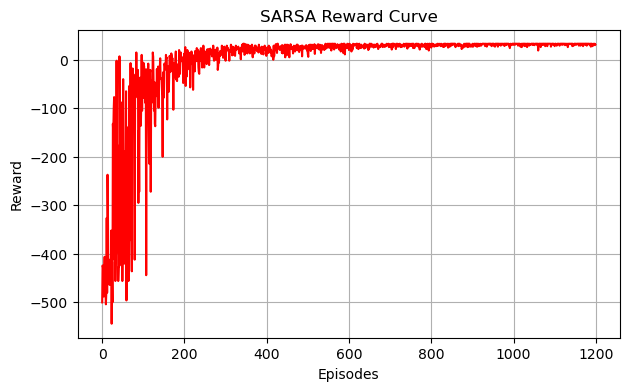

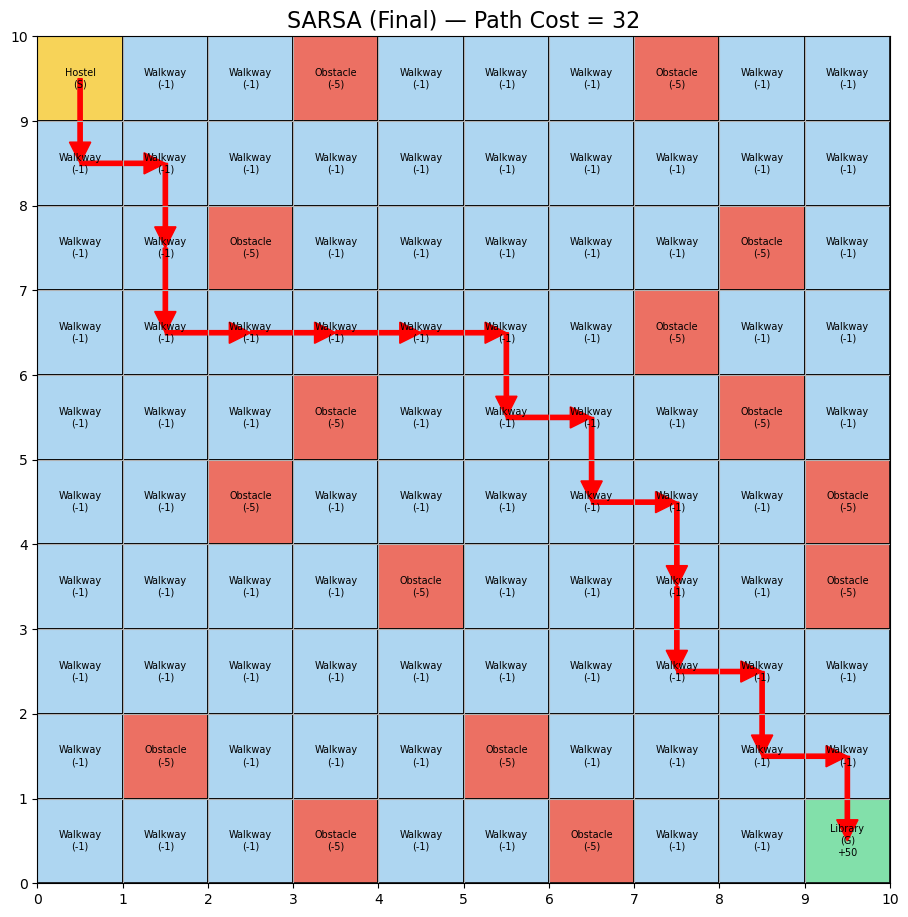

In [16]:
# ===========================
# SARSA (main logic cell)
# ===========================
import numpy as np
from matplotlib import pyplot as plt

SEED = 42
rng = np.random.default_rng(SEED)
np.random.seed(SEED+1)

alpha = 0.15
gamma = 0.95
episodes = 1200
max_steps = 300

Q_sarsa = np.zeros((rows, cols, len(ACTIONS)))
rewards_s = []

eps_start, eps_end, decay = 1.0, 0.02, 0.003

def select_eps_greedy_sarsa(Qtable, state, eps):
    if rng.random() < eps:
        return int(rng.integers(0, len(ACTIONS)))
    return int(np.argmax(Qtable[state]))

def evaluate_greedy(Qtable, max_steps_eval=500):
    s = START
    path = [s]; visited = set([s])
    for _ in range(max_steps_eval):
        a = int(np.argmax(Qtable[s]))
        ns, r, done = step(s, ACTIONS[a])
        if ns == s or ns in visited:
            break
        path.append(ns); visited.add(ns)
        if done: break
        s = ns
    return path

for ep in range(episodes):
    s = START
    total = 0
    eps = eps_end + (eps_start - eps_end) * np.exp(-decay * ep)
    a = select_eps_greedy_sarsa(Q_sarsa, s, eps)
    for t in range(max_steps):
        ns, r, done = step(s, ACTIONS[a])
        na = select_eps_greedy_sarsa(Q_sarsa, ns, eps)
        # SARSA update (note: r already contains obstacle penalty and step reward)
        Q_sarsa[s][a] += alpha * (r + gamma * Q_sarsa[ns][na] - Q_sarsa[s][a])

        total += r
        s, a = ns, na
        if done:
            break
    rewards_s.append(total)

# Evaluate
path_sarsa = evaluate_greedy(Q_sarsa)
cost_sarsa = 0
for cell in path_sarsa:
    if cell == GOAL:
        cost_sarsa += REWARD_GOAL; break
    elif cell in OBSTACLES:
        cost_sarsa += REWARD_OBSTACLE
    else:
        cost_sarsa += REWARD_NORMAL

print("SARSA Path:", path_sarsa)
print("SARSA Cost:", cost_sarsa)
print("SARSA Final Episode Reward:", rewards_s[-1])

plt.figure(figsize=(7,4)); plt.plot(rewards_s, color='red'); plt.title("SARSA Reward Curve"); plt.xlabel("Episodes"); plt.ylabel("Reward"); plt.grid(True); plt.show()
visualize_path(path_sarsa, cost_sarsa, "SARSA (Final)", color="red")


TD-Lambda Path: [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 4), (4, 5), (5, 5), (5, 6), (6, 6), (7, 6), (7, 7), (8, 7), (8, 8), (9, 8), (9, 9)]
TD-Lambda Cost: 32
TD-Lambda Final Episode Reward: 33


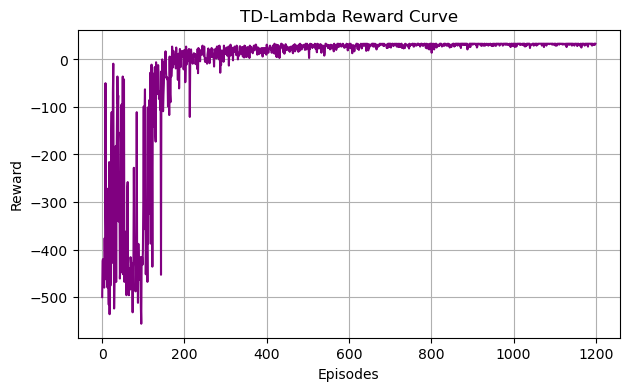

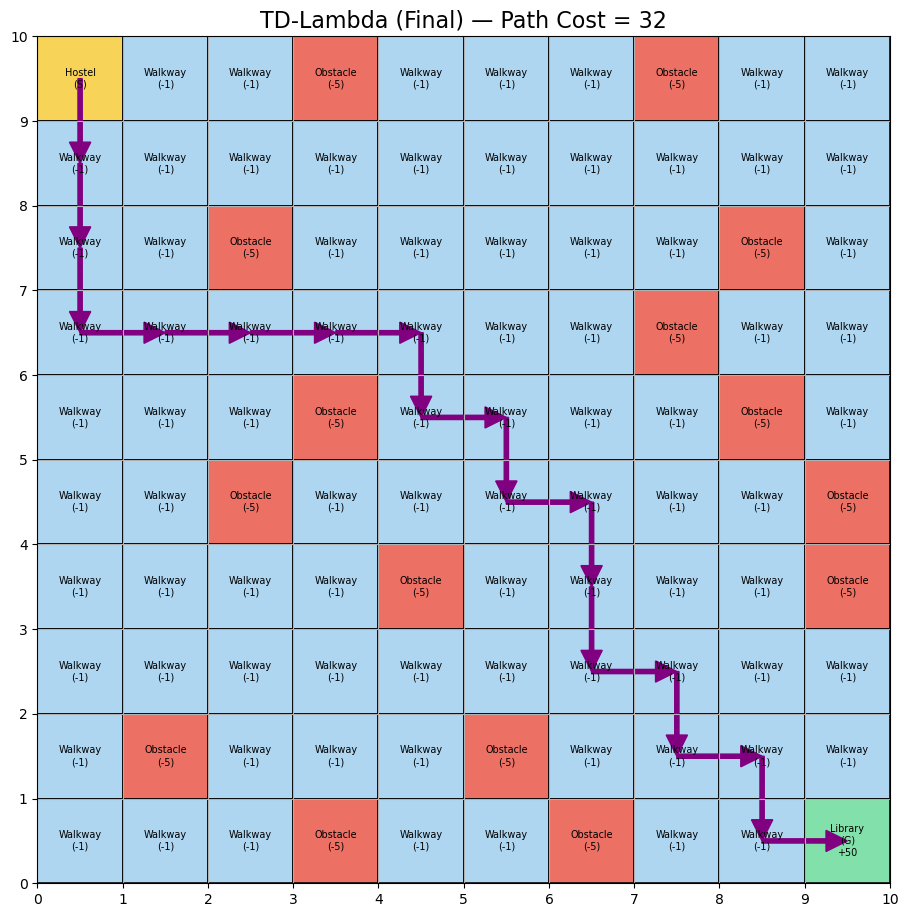

In [17]:
# ===========================
# TD-Lambda (main logic cell)
# ===========================
import numpy as np
from matplotlib import pyplot as plt

SEED = 42
rng = np.random.default_rng(SEED)
np.random.seed(SEED+3)

alpha = 0.15
gamma = 0.95
_lambda = 0.8
episodes = 1200
max_steps = 300

Q_td = np.zeros((rows, cols, len(ACTIONS)))
rewards_td = []

eps_start, eps_end, decay = 1.0, 0.02, 0.003

def select_eps_greedy_td(Qtable, state, eps):
    if rng.random() < eps:
        return int(rng.integers(0, len(ACTIONS)))
    return int(np.argmax(Qtable[state]))

def eval_greedy_td(Qtable, max_steps_eval=500):
    s = START; path=[s]; visited={s}
    for _ in range(max_steps_eval):
        a = int(np.argmax(Qtable[s]))
        ns, r, done = step(s, ACTIONS[a])
        if ns == s or ns in visited:
            break
        path.append(ns); visited.add(ns)
        if done: break
        s = ns
    return path

for ep in range(episodes):
    E = np.zeros_like(Q_td)
    s = START
    total = 0
    eps = eps_end + (eps_start - eps_end) * np.exp(-decay * ep)
    for t in range(max_steps):
        a = select_eps_greedy_td(Q_td, s, eps)
        ns, r, done = step(s, ACTIONS[a])
        td_error = r + gamma * np.max(Q_td[ns]) - Q_td[s][a]
        E[s][a] += 1
        Q_td += alpha * td_error * E
        E *= gamma * _lambda
        total += r
        s = ns
        if done:
            break
    rewards_td.append(total)

# Evaluate
path_td = eval_greedy_td(Q_td)
cost_td = 0
for cell in path_td:
    if cell == GOAL:
        cost_td += REWARD_GOAL; break
    elif cell in OBSTACLES:
        cost_td += REWARD_OBSTACLE
    else:
        cost_td += REWARD_NORMAL

print("TD-Lambda Path:", path_td)
print("TD-Lambda Cost:", cost_td)
print("TD-Lambda Final Episode Reward:", rewards_td[-1])

plt.figure(figsize=(7,4)); plt.plot(rewards_td, color='purple'); plt.title("TD-Lambda Reward Curve"); plt.xlabel("Episodes"); plt.ylabel("Reward"); plt.grid(True); plt.show()
visualize_path(path_td, cost_td, "TD-Lambda (Final)", color="purple")



  MONTE CARLO RESULT
Path: [(0, 0), (0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 3), (3, 4), (4, 4), (4, 5), (4, 6), (5, 6), (5, 7), (6, 7), (6, 8), (7, 8), (8, 8), (8, 9), (9, 9)]
Cost: 33
Final Episode Reward: 33


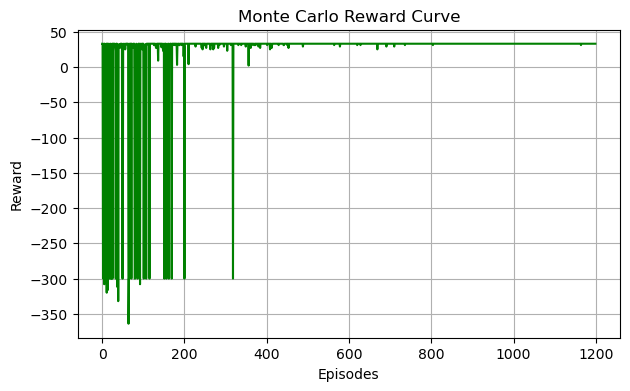

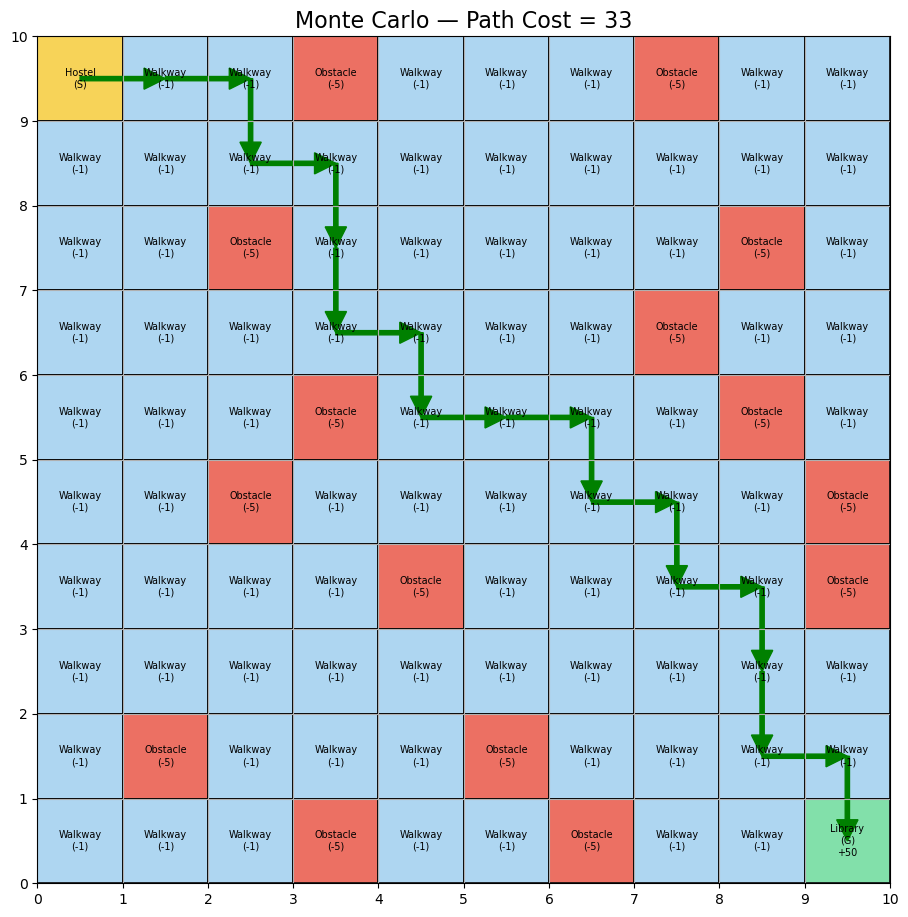

In [33]:
# ================================================================
#             MONTE CARLO CONTROL (SMART EXPLORATION)
# ================================================================

import numpy as np
import matplotlib.pyplot as plt

episodes = 1200
gamma = 0.9
alpha = 0.12
epsilon_start = 1.0
epsilon_end   = 0.05
decay_rate    = 0.002
MAX_STEPS = 300

Q_mc = np.zeros((rows, cols, len(ACTIONS)))
mc_rewards = []


# ================================================================
#          SMART ε-SOFT ACTION SELECTION (UPDATED)
# ================================================================
def select_action_mc(Q, state, epsilon):
    
    # SMART EXPLORATION
    if np.random.rand() < epsilon:
        best_actions = []
        best_dist = 999

        for i, (dr, dc) in enumerate(ACTIONS):
            rr, cc = state[0] + dr, state[1] + dc

            # Skip invalid moves
            if rr < 0 or rr >= rows or cc < 0 or cc >= cols:
                continue

            # Skip obstacles
            if (rr, cc) in OBSTACLES:
                continue

            # Manhattan distance to goal
            dist = abs(GOAL[0] - rr) + abs(GOAL[1] - cc)

            if dist < best_dist:
                best_dist = dist
                best_actions = [i]
            elif dist == best_dist:
                best_actions.append(i)

        # If something goes wrong, choose fully random
        if len(best_actions) == 0:
            return np.random.choice(len(ACTIONS))

        return np.random.choice(best_actions)

    # GREEDY ACTION
    return int(np.argmax(Q[state]))


# ================================================================
#                 FULL MONTE CARLO TRAINING LOOP
# ================================================================
for ep in range(episodes):

    epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-decay_rate * ep)

    state = START
    episode = []
    done = False

    for _ in range(MAX_STEPS):

        action_index = select_action_mc(Q_mc, state, epsilon)

        next_state, reward, done = step(state, ACTIONS[action_index])

        episode.append((state, action_index, reward))

        state = next_state
        if done:
            break

    mc_rewards.append(sum([x[2] for x in episode]))

    # ------- FIRST-VISIT MC UPDATE (BACKWARD) -------
    G = 0
    visited = set()

    for s, a, r in reversed(episode):
        G = r + gamma * G

        if (s, a) not in visited:
            visited.add((s, a))
            Q_mc[s][a] += alpha * (G - Q_mc[s][a])


# ================================================================
#                  EXTRACT OPTIMAL PATH
# ================================================================
path_mc = [START]
state = START
visited_states = {START}
total_cost = 0

for _ in range(MAX_STEPS):

    a = int(np.argmax(Q_mc[state]))
    next_state, reward, done = step(state, ACTIONS[a])

    if next_state in visited_states:
        break

    visited_states.add(next_state)
    path_mc.append(next_state)
    total_cost += reward
    state = next_state

    if done:
        break


print("\n=======================")
print("  MONTE CARLO RESULT")
print("=======================")
print("Path:", path_mc)
print("Cost:", total_cost)
print("Final Episode Reward:", mc_rewards[-1])


# ================================================================
#            TRAINING REWARD GRAPH 
# ================================================================

plt.figure(figsize=(7,4))
plt.plot(mc_rewards, color="green")
plt.title("Monte Carlo Reward Curve")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.grid(True)
plt.show()


# ================================================================
#                VISUALIZE MONTE CARLO PATH
# ================================================================
visualize_path(path_mc, total_cost, "Monte Carlo", color="green")

plt.show()
